MovieWriter imagemagick unavailable; using Pillow instead.


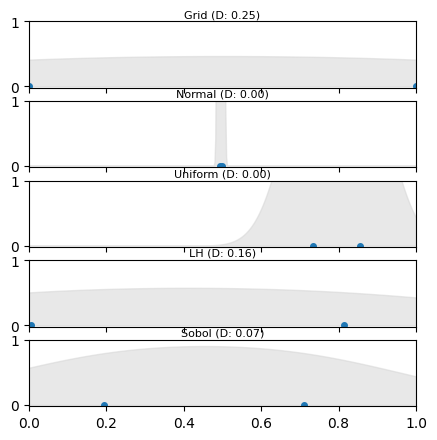

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde, qmc
import math

# Helper function for Sobol sequence
def next_power_of_2(n):
    return int(2**math.ceil(math.log2(n)))

# Placeholder for a disparity calculation
def calculate_disparity(samples):
    # Example: Using variance as a placeholder
    return np.var(samples)

# Sample size and calculation for Sobol sequence
n_samples = 25
next_pow2 = next_power_of_2(n_samples)

fig, axs = plt.subplots(5, 1, figsize=(5, 5), sharex=True, sharey=True)
methods = ['Grid', 'Normal', 'Uniform', 'LH', 'Sobol']

# Define a uniform range for KDE plots
x_range = np.linspace(0, 1, 500)

def resample(method, frame):
    if method == 'Grid':
        return np.linspace(0, 1, frame + 1)
    elif method == 'Normal':
        return np.clip(np.random.normal(0.5, 0.15, frame + 1), 0, 1)
    elif method == 'Uniform':
        return np.random.uniform(0, 1, frame + 1)
    elif method == 'LH':
        sampler = qmc.LatinHypercube(d=1)
        return qmc.scale(sampler.random(n=frame + 1), 0, 1).flatten()
    elif method == 'Sobol':
        sampler = qmc.Sobol(d=1)
        points = qmc.scale(sampler.random(n=next_pow2), 0, 1).flatten()
        return points[:frame + 1]

def update(frame):
    for ax, method in zip(axs, methods):
        ax.clear()
        current_samples = resample(method, frame + 1)  # Frame + 1 for non-zero samples
        disparity = calculate_disparity(current_samples)

        # Plot KDE for visualizing the distribution
        if len(current_samples) > 1:  # KDE requires more than one sample
            kde = gaussian_kde(current_samples)
            kde_values = kde(x_range)
            ax.fill_between(x_range, 0, kde_values, color="lightgray", alpha=0.5)
        
        ax.plot(current_samples, np.zeros_like(current_samples), 'o', markersize=4)
        ax.set_title(f"{method} (D: {disparity:.2f})", fontsize=8, pad=3)  # Reduced font size and text
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.02, 1)  # Adjusted for visibility of KDE

ani = FuncAnimation(fig, update, frames=n_samples, repeat=False)

# Save the animation; ensure you have ImageMagick installed for GIF
ani.save('disparity_with_distribution.gif', writer='imagemagick', fps=2)

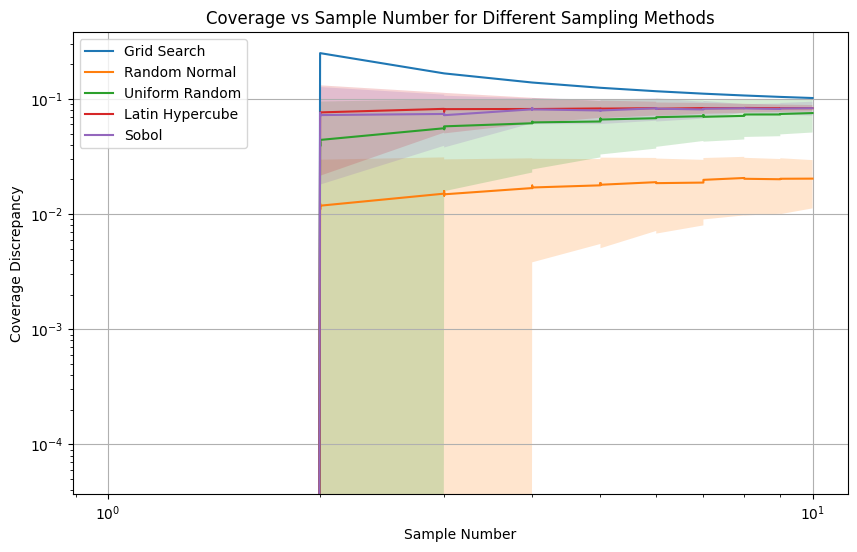

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, qmc
from scipy.stats.qmc import Sobol
import math

# Function to calculate discrepancy
def calculate_discrepancy(samples):
    # Here, we're using variance as a simple measure of discrepancy.
    return np.var(samples)

# Function to find the next power of 2
def next_power_of_2(n):
    return 2 ** np.ceil(np.log2(n)).astype(int)

# Adjusted function to resample according to the method
def resample(method, n_samples):
    if method == 'Grid Search':
        return np.linspace(0, 1, n_samples)
    elif method == 'Random Normal':
        return np.clip(np.random.normal(0.5, 0.15, n_samples), 0, 1)
    elif method == 'Uniform Random':
        return np.random.uniform(0, 1, n_samples)
    elif method == 'Latin Hypercube':
        return qmc.scale(qmc.LatinHypercube(d=1).random(n_samples), 0, 1).flatten()
    elif method == 'Sobol':
        # Sample up to the next power of 2 and then trim
        n_samples_pow2 = next_power_of_2(n_samples)
        samples = qmc.scale(Sobol(d=1).random(n_samples_pow2), 0, 1).flatten()
        return samples[:n_samples]

# Monte Carlo simulation setup
n_iterations = 1000
sample_numbers = np.logspace(0, 1, 50, dtype=int)  # Sample numbers from 1 to 100 on a log scale
methods = ['Grid Search', 'Random Normal', 'Uniform Random', 'Latin Hypercube', 'Sobol']
discrepancies = {method: {'mean': [], 'std': []} for method in methods}

for n_samples in sample_numbers:
    for method in methods:
        method_discrepancies = []
        for _ in range(n_iterations):
            samples = resample(method, n_samples)
            discrepancy = calculate_discrepancy(samples)
            method_discrepancies.append(discrepancy)
        discrepancies[method]['mean'].append(np.mean(method_discrepancies))
        discrepancies[method]['std'].append(np.std(method_discrepancies))


# Plotting
plt.figure(figsize=(10, 6))
for method in methods:
    means = discrepancies[method]['mean']
    stds = discrepancies[method]['std']
    plt.plot(sample_numbers, means, label=method)
    plt.fill_between(sample_numbers, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

plt.yscale('log')
plt.ylim(1e-2, 0.25)
plt.xlabel('Sample Number')
plt.ylabel('Coverage Discrepancy')
plt.title('Coverage vs Sample Number for Different Sampling Methods')
plt.legend()
plt.grid(True)
plt.show()


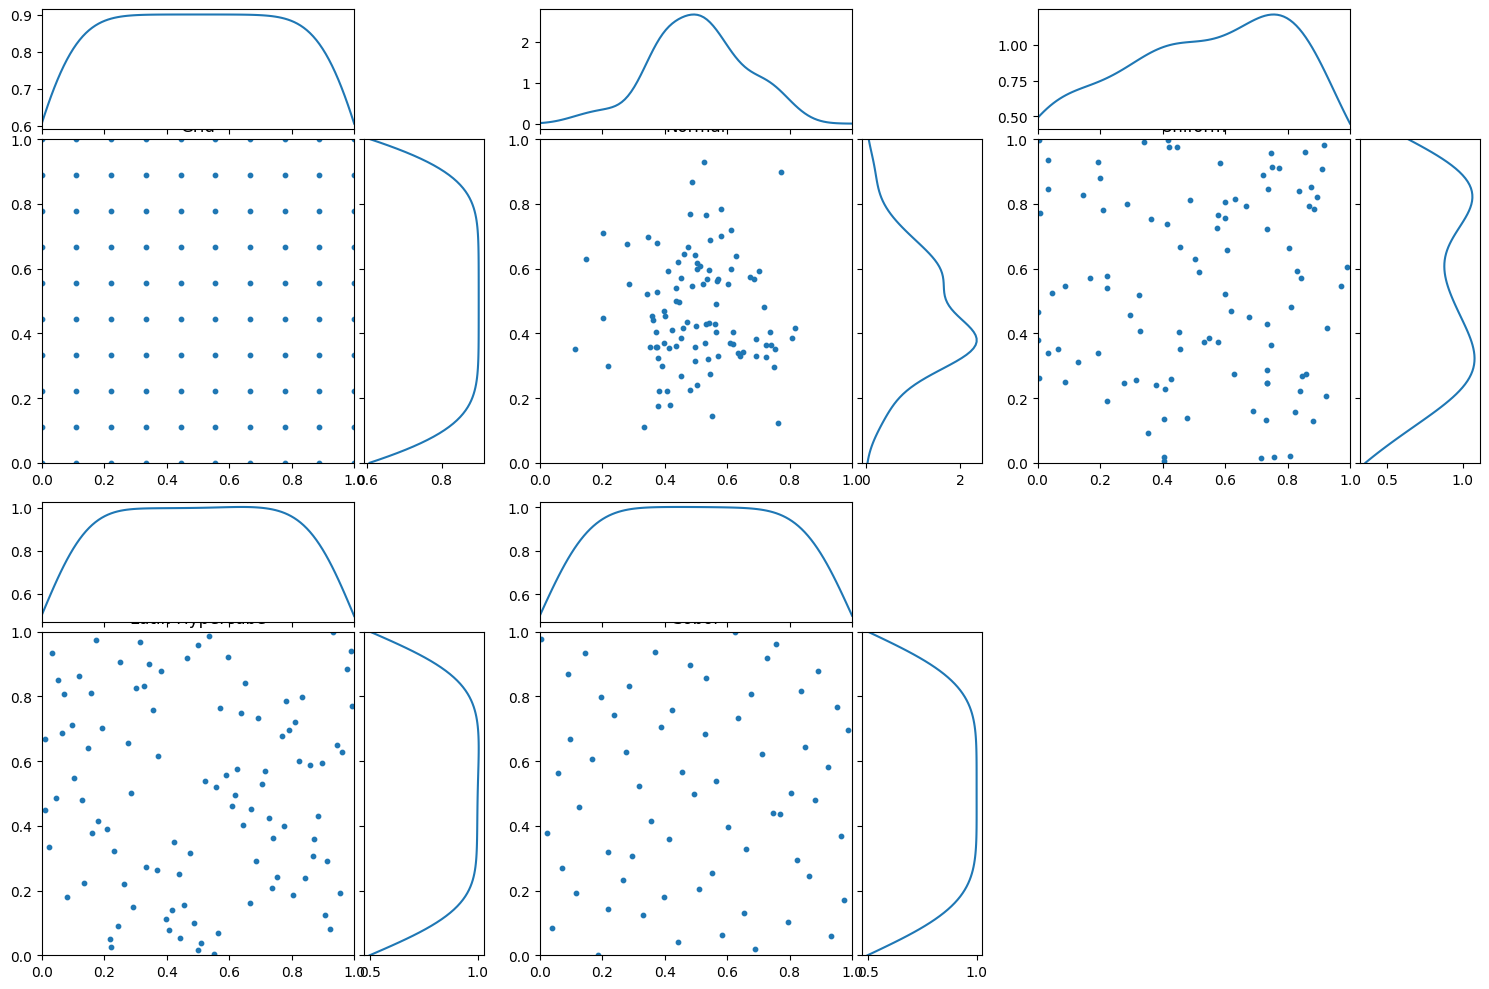

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde, qmc
from scipy.stats.qmc import Sobol
import sobol_seq
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sample size
n_samples = 100

# Generate samples for each method in 2D
grid_samples = np.array(np.meshgrid(np.linspace(0, 1, int(np.sqrt(n_samples))), np.linspace(0, 1, int(np.sqrt(n_samples))))).T.reshape(-1, 2)
normal_samples = np.clip(np.random.normal(0.5, 0.15, (n_samples, 2)), 0, 1)
uniform_samples = np.random.uniform(0, 1, (n_samples, 2))
latin_hypercube_samples = qmc.scale(qmc.LatinHypercube(d=2).random(n_samples), [0, 0], [1, 1])
sobol_samples = Sobol(d=2).random_base2(m=int(np.log2(n_samples)))

samples_methods = {
    'Grid': grid_samples,
    'Normal': normal_samples,
    'Uniform': uniform_samples,
    'Latin Hypercube': latin_hypercube_samples,
    'Sobol': sobol_samples
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
methods = list(samples_methods.keys())

# Plot 2D samples and their KDEs
for i, method in enumerate(methods):
    ax = axs[i]
    samples = samples_methods[method]

    # Plot 2D samples
    ax.scatter(samples[:, 0], samples[:, 1], s=10, label=method)

    # Plot KDE for each parameter on the margins
    x_kde = gaussian_kde(samples[:, 0])
    y_kde = gaussian_kde(samples[:, 1])
    x_range = np.linspace(0, 1, 100)
    y_range = np.linspace(0, 1, 100)

    # Creating secondary axes for KDE plots
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    ax_histx.plot(x_range, x_kde(x_range))
    ax_histy.plot(y_kde(y_range), y_range)

    # Hide tick labels for histogram axes
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(method)

# Remove unused subplots if any
for i in range(len(methods), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


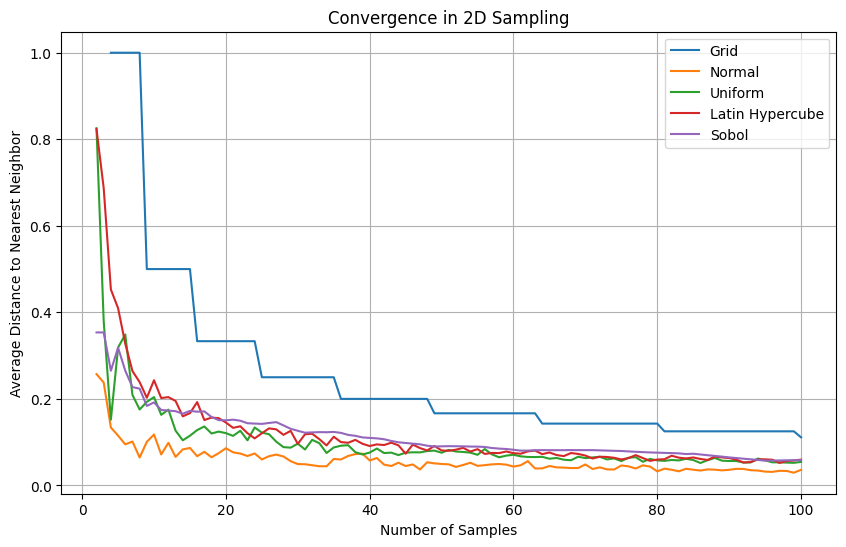

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import qmc
from sobol_seq import i4_sobol_generate

def calculate_average_distance(samples):
    """Calculate the average distance to the nearest neighbor for each point."""
    distances = cdist(samples, samples, 'euclidean')
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances
    return np.mean(np.min(distances, axis=1))

def generate_samples(method, n_samples):
    """Generate 2D samples using specified method."""
    if method == "Grid":
        side = int(np.sqrt(n_samples))
        x, y = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
        samples = np.vstack([x.ravel(), y.ravel()]).T
    elif method == "Normal":
        samples = np.clip(np.random.normal(0.5, 0.15, (n_samples, 2)), 0, 1)
    elif method == "Uniform":
        samples = np.random.uniform(0, 1, (n_samples, 2))
    elif method == "Latin Hypercube":
        sampler = qmc.LatinHypercube(d=2)
        samples = qmc.scale(sampler.random(n=n_samples), [0, 0], [1, 1])
    elif method == "Sobol":
        samples = qmc.scale(i4_sobol_generate(2, n_samples), [0, 0], [1, 1])
    return samples

methods = ["Grid", "Normal", "Uniform", "Latin Hypercube", "Sobol"]
n_samples_list = np.arange(1, 101)  # From 1 to 100 samples
results = {method: [] for method in methods}

# Run simulation
for n_samples in n_samples_list:
    for method in methods:
        samples = generate_samples(method, n_samples)
        avg_distance = calculate_average_distance(samples)
        results[method].append(avg_distance)

# Plotting
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(n_samples_list, results[method], label=method)

plt.xlabel('Number of Samples')
plt.ylabel('Average Distance to Nearest Neighbor')
plt.title('Convergence in 2D Sampling')
plt.legend()
plt.grid(True)
plt.show()


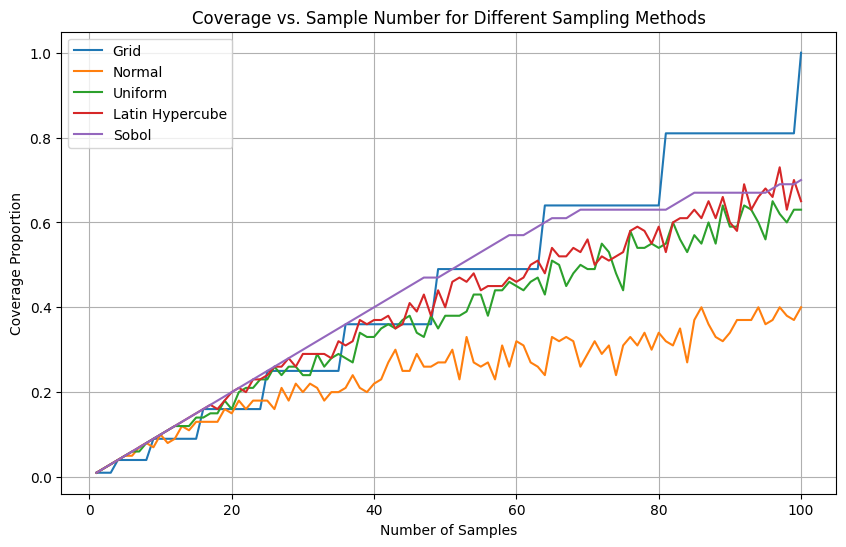

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sobol_seq import i4_sobol_generate

def calculate_coverage(samples, grid_size=10):
    """Calculate the coverage discrepancy based on grid cell occupancy."""
    occupied_cells = set()
    for x, y in samples:
        cell_x = min(int(x * grid_size), grid_size - 1)
        cell_y = min(int(y * grid_size), grid_size - 1)
        occupied_cells.add((cell_x, cell_y))
    total_cells = grid_size**2
    coverage = len(occupied_cells) / total_cells
    return coverage

def generate_samples(method, n_samples):
    """Generate 2D samples using specified method."""
    if method == "Grid":
        side = int(np.sqrt(n_samples))
        x, y = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
        samples = np.vstack([x.ravel(), y.ravel()]).T
    elif method == "Normal":
        samples = np.clip(np.random.normal(0.5, 0.15, (n_samples, 2)), 0, 1)
    elif method == "Uniform":
        samples = np.random.uniform(0, 1, (n_samples, 2))
    elif method == "Latin Hypercube":
        sampler = qmc.LatinHypercube(d=2)
        samples = qmc.scale(sampler.random(n=n_samples), [0, 0], [1, 1])
    elif method == "Sobol":
        samples = qmc.scale(i4_sobol_generate(2, n_samples), [0, 0], [1, 1])
    return samples

methods = ["Grid", "Normal", "Uniform", "Latin Hypercube", "Sobol"]
n_samples_list = np.arange(1, 101)  # From 1 to 100 samples
results = {method: [] for method in methods}

# Run simulation
for n_samples in n_samples_list:
    for method in methods:
        samples = generate_samples(method, n_samples)
        coverage = calculate_coverage(samples)
        results[method].append(coverage)

# Plotting
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(n_samples_list, results[method], label=method)

plt.xlabel('Number of Samples')
plt.ylabel('Coverage Proportion')
plt.title('Coverage vs. Sample Number for Different Sampling Methods')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


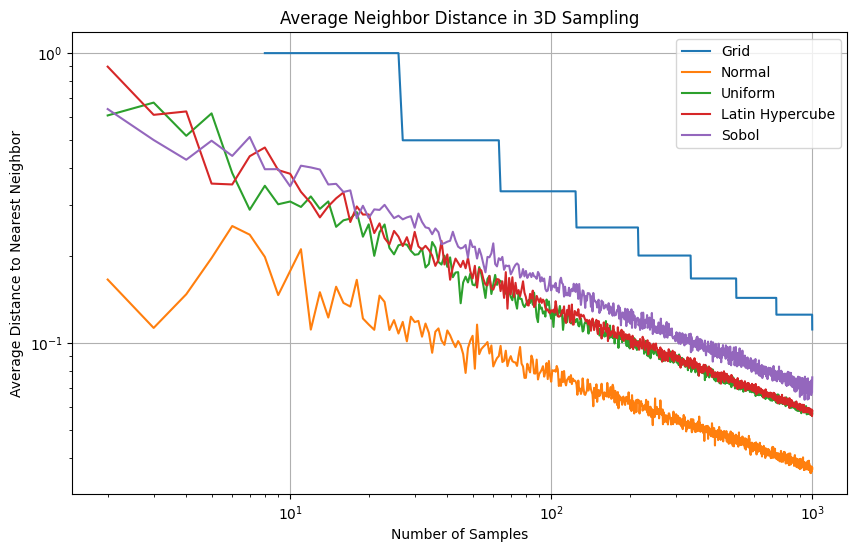

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import qmc

def calculate_average_distance(samples):
    """Calculate the average distance to the nearest neighbor for each point."""
    if len(samples) <= 1:
        return np.nan  # Not applicable for one or zero points
    distances = cdist(samples, samples, 'euclidean')
    np.fill_diagonal(distances, np.inf)  # Ignore distance to self
    return np.mean(np.min(distances, axis=1))

def generate_samples(method, n_samples, d=3):
    """Generate 3D samples using the specified method."""
    if method == "Grid":
        # Approximate a grid in 3D - not perfectly uniform for all n_samples
        side = int(np.cbrt(n_samples))
        grid = np.linspace(0, 1, side)
        samples = np.array(np.meshgrid(grid, grid, grid)).T.reshape(-1, 3)
    elif method == "Normal":
        samples = np.clip(np.random.normal(0.5, 0.15, (n_samples, d)), 0, 1)
    elif method == "Uniform":
        samples = np.random.uniform(0, 1, (n_samples, d))
    elif method == "Latin Hypercube":
        sampler = qmc.LatinHypercube(d=d)
        samples = qmc.scale(sampler.random(n=n_samples), [0]*d, [1]*d)
    elif method == "Sobol":
        sampler = qmc.Sobol(d=d)
        samples = qmc.scale(sampler.random(n=n_samples), [0]*d, [1]*d)
    return samples

methods = ["Grid", "Normal", "Uniform", "Latin Hypercube", "Sobol"]
n_samples_list = np.arange(1, 1001)  # From 1 to 100 samples
results = {method: [] for method in methods}

# Simulation
for n_samples in n_samples_list:
    for method in methods:
        samples = generate_samples(method, n_samples, d=3)
        avg_distance = calculate_average_distance(samples)
        results[method].append(avg_distance)

# Plotting
plt.figure(figsize=(10, 6))
for method, distances in results.items():
    plt.plot(n_samples_list, distances, label=method)

plt.xlabel('Number of Samples')
plt.ylabel('Average Distance to Nearest Neighbor')
plt.title('Average Neighbor Distance in 3D Sampling')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


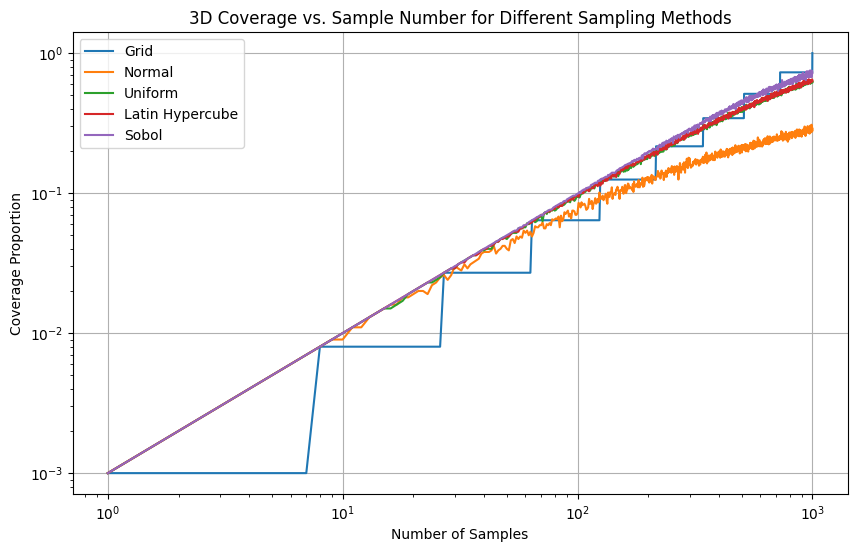

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.spatial.distance import cdist

def calculate_3d_coverage(samples, grid_size=10):
    """Calculate the coverage discrepancy based on 3D grid cell occupancy."""
    occupied_cells = set()
    for x, y, z in samples:
        cell_x = min(int(x * grid_size), grid_size - 1)
        cell_y = min(int(y * grid_size), grid_size - 1)
        cell_z = min(int(z * grid_size), grid_size - 1)
        occupied_cells.add((cell_x, cell_y, cell_z))
    total_cells = grid_size**3
    coverage = len(occupied_cells) / total_cells
    return coverage

def generate_3d_samples(method, n_samples):
    """Generate 3D samples using the specified method."""
    if method == "Grid":
        side = int(np.cbrt(n_samples))
        x, y, z = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side), np.linspace(0, 1, side))
        samples = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
    elif method == "Normal":
        samples = np.clip(np.random.normal(0.5, 0.15, (n_samples, 3)), 0, 1)
    elif method == "Uniform":
        samples = np.random.uniform(0, 1, (n_samples, 3))
    elif method == "Latin Hypercube":
        sampler = qmc.LatinHypercube(d=3)
        samples = qmc.scale(sampler.random(n=n_samples), [0, 0, 0], [1, 1, 1])
    elif method == "Sobol":
        sampler = qmc.Sobol(d=3)
        samples = qmc.scale(sampler.random_base2(m=int(np.ceil(np.log2(n_samples)))), [0, 0, 0], [1, 1, 1])[:n_samples]
    return samples

methods = ["Grid", "Normal", "Uniform", "Latin Hypercube", "Sobol"]
n_samples_list = np.arange(1, 1001)  # From 1 to 100 samples
results = {method: [] for method in methods}

# Run simulation
for n_samples in n_samples_list:
    for method in methods:
        samples = generate_3d_samples(method, n_samples)
        coverage = calculate_3d_coverage(samples)
        results[method].append(coverage)

# Plotting
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(n_samples_list, results[method], label=method)

plt.xlabel('Number of Samples')
plt.ylabel('Coverage Proportion')
plt.title('3D Coverage vs. Sample Number for Different Sampling Methods')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


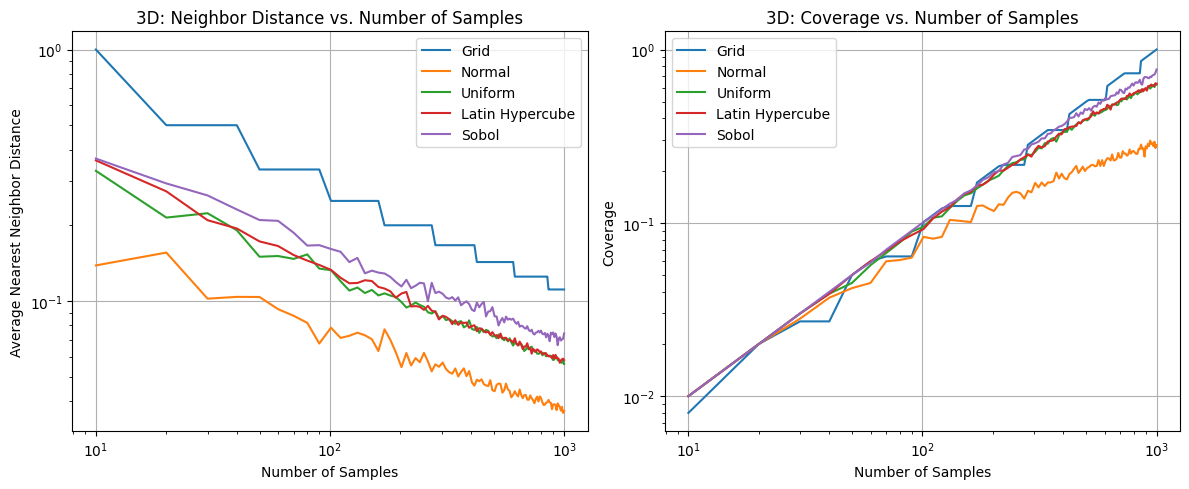

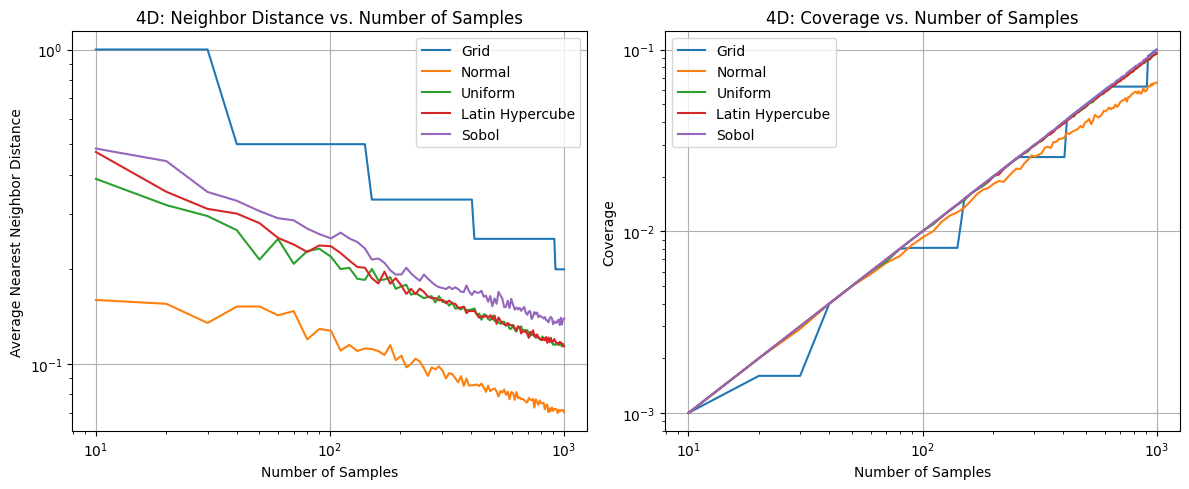

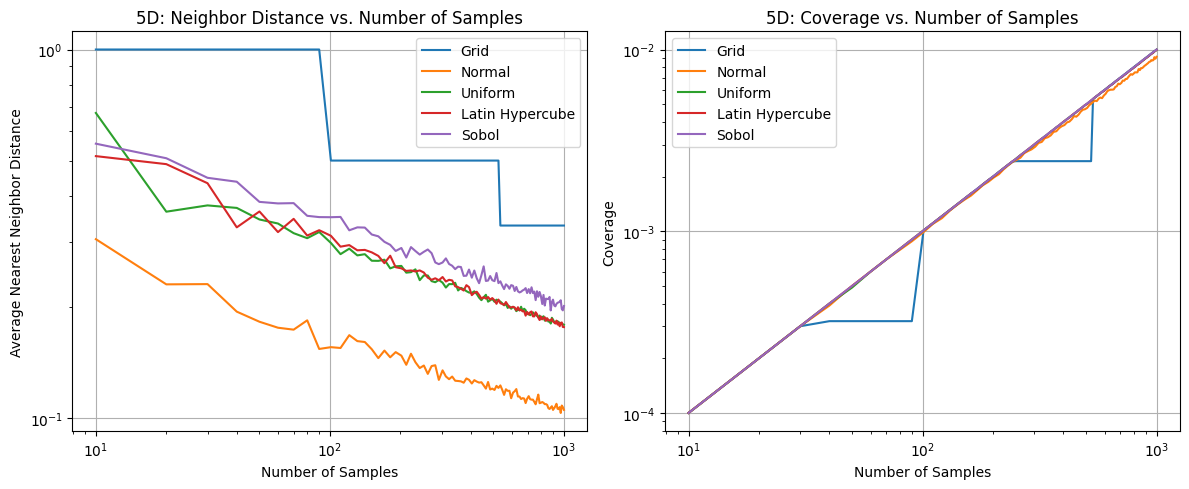

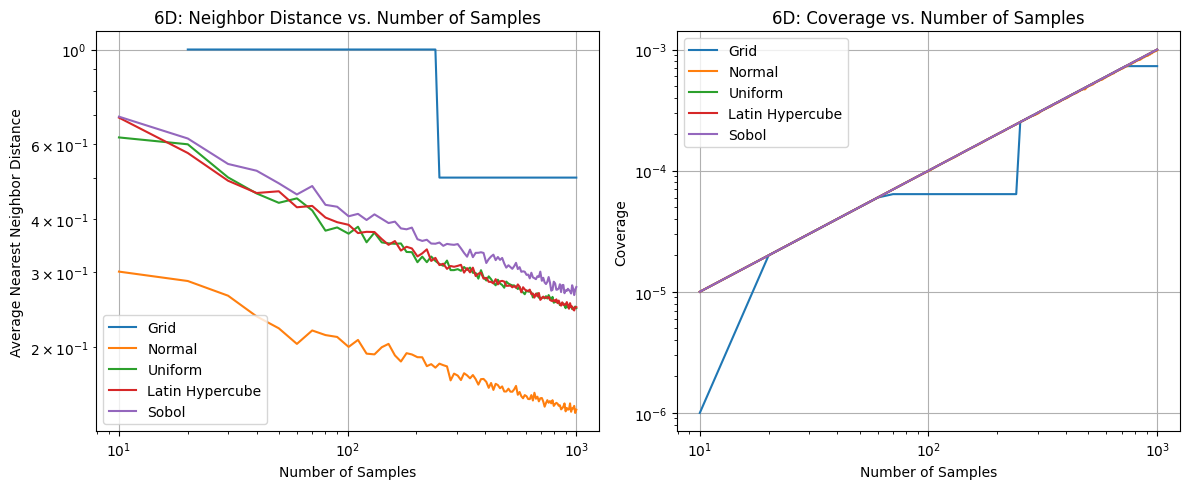

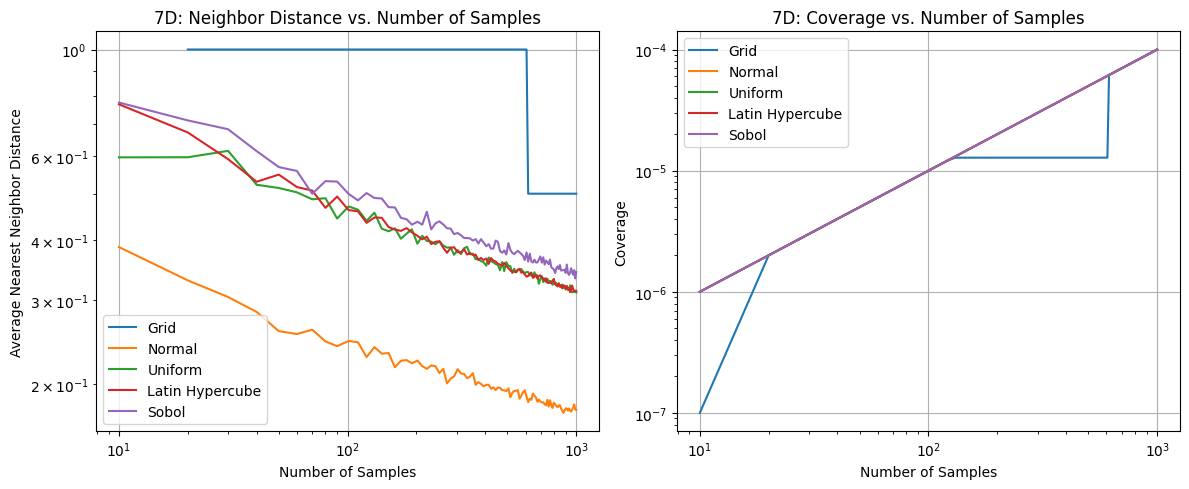

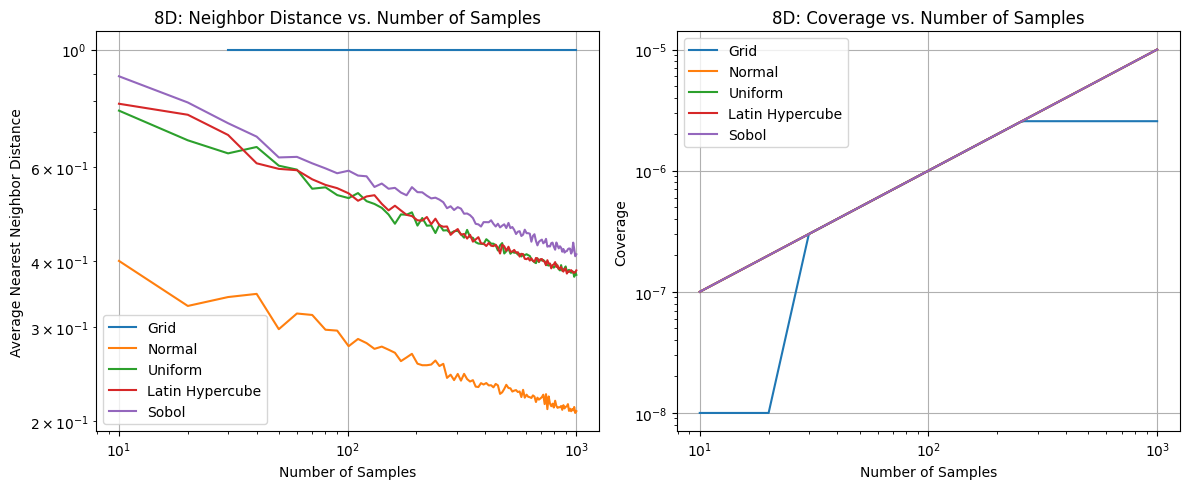

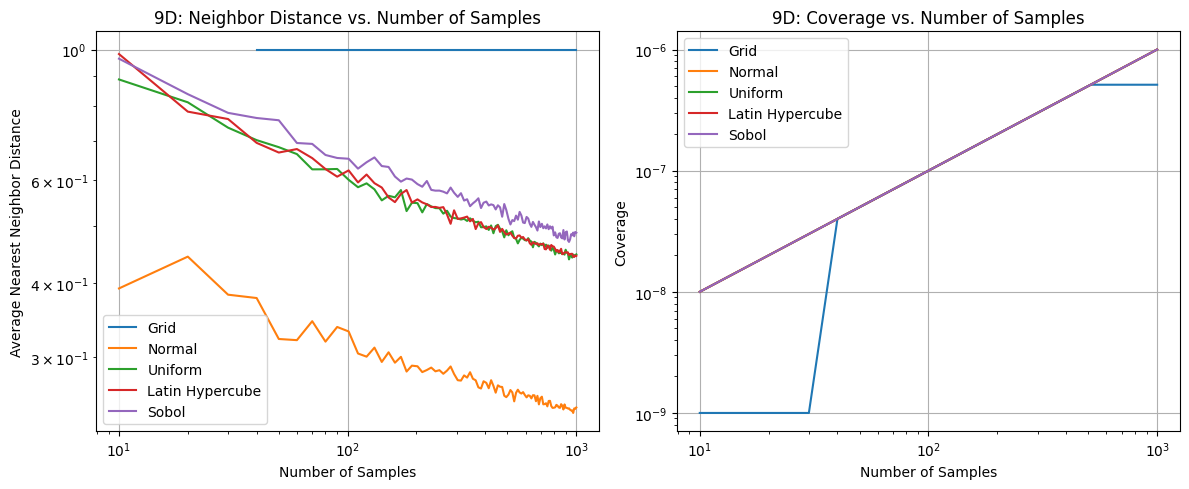

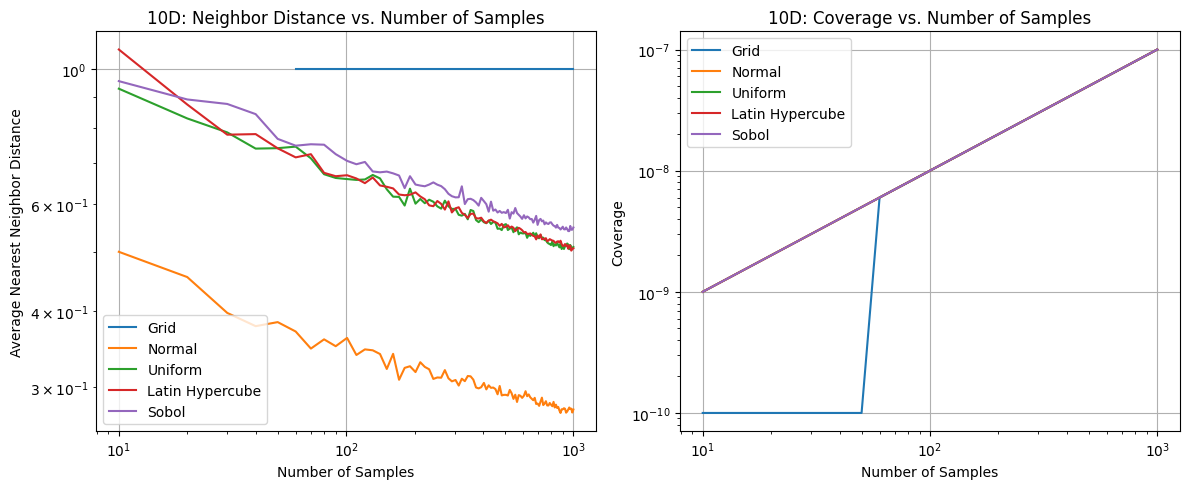

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
from scipy.spatial.distance import pdist, squareform, cdist

def calculate_average_nearest_neighbor_distance(samples):
    if len(samples) > 1:
        distances = squareform(pdist(samples))
        np.fill_diagonal(distances, np.inf)  # Ignore self-distance
        return np.mean(np.min(distances, axis=0))
    else:
        return np.inf

def calculate_coverage(samples, d, grid_density=10):
    unique_cells = len(set(tuple(sample // (1/grid_density)) for sample in samples))
    coverage = unique_cells / (grid_density ** d)
    return coverage

def generate_samples(method, n_samples, d):
    if method == "Grid":
        samples_per_side = int(np.round(n_samples ** (1/d)))
        axes = [np.linspace(0, 1, samples_per_side) for _ in range(d)]
        mesh = np.meshgrid(*axes)
        samples = np.vstack([axis.ravel() for axis in mesh]).T[:n_samples]
    elif method == "Normal":
        samples = np.clip(norm.rvs(0.5, 0.15, size=(n_samples, d)), 0, 1)
    elif method == "Uniform":
        samples = np.random.uniform(0, 1, (n_samples, d))
    elif method == "Latin Hypercube":
        sampler = qmc.LatinHypercube(d=d)
        samples = qmc.scale(sampler.random(n=n_samples), [0]*d, [1]*d)
    elif method == "Sobol":
        sampler = qmc.Sobol(d=d)
        m = int(np.ceil(np.log2(n_samples)))
        samples = sampler.random_base2(m=m)[:n_samples]
    else:
        raise ValueError("Method not recognized")
    return samples

max_samples = 1000
sample_checkpoints = np.linspace(0, max_samples, 100, dtype=int)[1:]  # Exclude zero
dimensions = range(3, 11)  # From 1D to 5D
methods = ["Grid", "Normal", "Uniform", "Latin Hypercube", "Sobol"]

# Prepare result storage
results_distance = {d: {method: [] for method in methods} for d in dimensions}
results_coverage = {d: {method: [] for method in methods} for d in dimensions}

for d in dimensions:
    for n_samples in sample_checkpoints:
        for method in methods:
            samples = generate_samples(method, n_samples, d)
            avg_distance = calculate_average_nearest_neighbor_distance(samples)
            coverage = calculate_coverage(samples, d, grid_density=10)
            results_distance[d][method].append(avg_distance)
            results_coverage[d][method].append(coverage)

# Plotting
for d in dimensions:
    plt.figure(figsize=(12, 5))
    
    # Plot average nearest neighbor distance
    plt.subplot(1, 2, 1)
    for method in methods:
        plt.plot(sample_checkpoints, results_distance[d][method], label=method)
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Nearest Neighbor Distance')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{d}D: Neighbor Distance vs. Number of Samples')
    plt.legend()
    plt.grid(True)

    # Plot coverage
    plt.subplot(1, 2, 2)
    for method in methods:
        plt.plot(sample_checkpoints, results_coverage[d][method], label=method)
    plt.xlabel('Number of Samples')
    plt.ylabel('Coverage')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{d}D: Coverage vs. Number of Samples')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


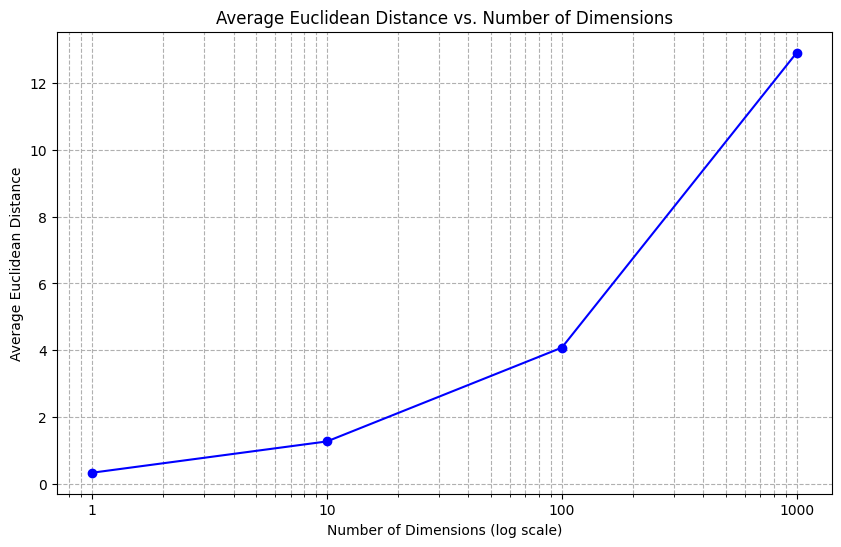

(None,
 [0.3299564677663105, 1.2677213410012032, 4.07683566418057, 12.91130784156302])

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of dimensions and the number of point pairs
dimensions = [1, 10, 100, 1000]
num_pairs = 10000  # Number of pairs to generate for each dimensionality

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Initialize list to store average distances
average_distances = []

# Loop through each dimension
for dimension in dimensions:
    distances = []
    for _ in range(num_pairs):
        # Generate two random points in a unit hypercube for the current dimension
        point1 = np.random.rand(dimension)
        point2 = np.random.rand(dimension)
        # Calculate and store the Euclidean distance between the two points
        distances.append(euclidean_distance(point1, point2))
    # Calculate and store the average distance for this dimension
    average_distances.append(np.mean(distances))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dimensions, average_distances, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Number of Dimensions (log scale)')
plt.ylabel('Average Euclidean Distance')
plt.title('Average Euclidean Distance vs. Number of Dimensions')
plt.grid(True, which="both", ls="--")
plt.xticks(dimensions, labels=dimensions)
plt.show(), average_distances


C:\Users\jorda\AppData\Local\Temp\ipykernel_89600\2763143574.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)


  Dimension            Method  Discrepancy  Diversity Index
0         1   Random (Normal)     0.018933         0.181612
1         1  Random (Uniform)     0.000055         0.333179
2         1            Halton     0.000001         0.333676
3         1               LHS     0.000001         0.333669
4         1             Sobol     0.000001         0.333652


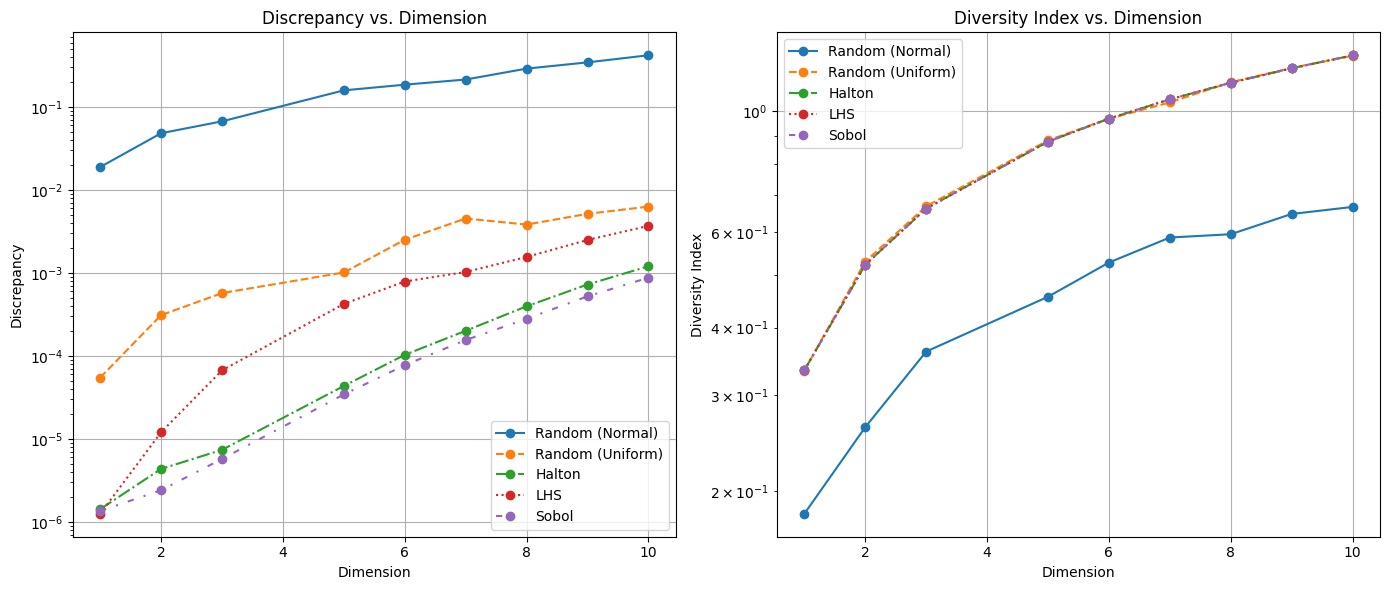

In [5]:
import numpy as np
from scipy.stats import qmc
from scipy.spatial.distance import pdist  # Corrected import
import pandas as pd
import matplotlib.pyplot as plt

# Define dimensions to explore
dimensions = [1, 2, 3, 5, 6, 7, 8, 9, 10]

# Initialize storage for metrics
metrics_df = pd.DataFrame(columns=['Dimension', 'Method', 'Discrepancy', 'Diversity Index'])

for dimension in dimensions:
    # Generate samples for each method
    samplers = {
        'Random (Normal)': np.random.randn(1000, dimension),
        'Random (Uniform)': np.random.rand(1000, dimension),
        'Halton': qmc.Halton(d=dimension).random(n=1000),
        'LHS': qmc.LatinHypercube(d=dimension).random(n=1000),
        'Sobol': qmc.Sobol(d=min(40, dimension), scramble=False).random_base2(m=int(np.ceil(np.log2(1000))))
    }
    
    rows_list = []  # Temporary list to store row data
    
    for method, samples in samplers.items():
        if method == 'Sobol' and samples.shape[0] > 1000:
            samples = samples[:1000, :dimension]  # Trim to 1000 samples and correct dimension
        
        # Normalize the samples from Normal distribution to fit in [0, 1]^d for fair comparison
        if method == 'Random (Normal)':
            samples = (samples - samples.min(0)) / (samples.max(0) - samples.min(0))
            
        # Discrepancy - using L2-star discrepancy for uniformity measurement
        discrepancy = qmc.discrepancy(samples, iterative=True)

        # Diversity Index - average pairwise distance
        diversity_index = np.mean(pdist(samples, 'euclidean'))

        # Store metrics in the temporary list
        rows_list.append({'Dimension': dimension, 'Method': method,
                          'Discrepancy': discrepancy, 'Diversity Index': diversity_index})

    # Convert list of rows into DataFrame and concatenate to the main DataFrame
    temp_df = pd.DataFrame(rows_list)
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

# Display part of the DataFrame for a sanity check
print(metrics_df.head())
# Display part of the DataFrame for a sanity check
metrics_df.head()
# Visualization of metrics across dimensions for each method
plt.figure(figsize=(14, 6))
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]


# Discrepancy Plot
plt.subplot(1, 2, 1)
for i, method in enumerate(samplers.keys()):
    subset = metrics_df[metrics_df['Method'] == method]
    plt.plot(subset['Dimension'], subset['Discrepancy'], marker='o', linestyle=line_styles[i % len(line_styles)], label=method)
plt.xlabel('Dimension')
plt.ylabel('Discrepancy')
plt.title('Discrepancy vs. Dimension')
plt.legend()
plt.yscale('log')
plt.grid(True)

# Diversity Index Plot
plt.subplot(1, 2, 2)
for i, method in enumerate(samplers.keys()):
    subset = metrics_df[metrics_df['Method'] == method]
    plt.plot(subset['Dimension'], subset['Diversity Index'], marker='o', linestyle=line_styles[i % len(line_styles)], label=method)
plt.xlabel('Dimension')
plt.ylabel('Diversity Index')
plt.title('Diversity Index vs. Dimension')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

